# Training AdaMM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as stats
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

from run import main, experiments
from utils import read_json

In [8]:
def compare_FO_ZO_plot(fo_data_dict, zo_data_dict):
    fig, axs = plt.subplots( 1, 3)
    scale = fo_data_dict.get("config").get("scale")
    fo_values= list(fo_data_dict.items())[1][1]
    zo_values= list(zo_data_dict.items())[1][1]
    n_epochs = len(zo_values[0].get("train_accuracies"))
    n_experiments = len(zo_values)
    fig.suptitle(f"FO vs ZO AdaMM: scale {scale:.4f}", fontsize=16)
    zo_acc = np.zeros((n_experiments,n_epochs))
    zo_train_loss =np.zeros((n_experiments,n_epochs))
    zo_test_loss = np.zeros((n_experiments,n_epochs))
    fo_acc = np.zeros((n_experiments,n_epochs))
    fo_train_loss = np.zeros((n_experiments,n_epochs))
    fo_test_loss = np.zeros((n_experiments,n_epochs))
    for i in range(n_experiments):
        zo_acc[i,:] = zo_values[i].get("train_accuracies")
        zo_train_loss[i,:] = zo_values[i].get("train_losses")
        zo_test_loss[i,:] = zo_values[i].get("validation_losses")
        fo_acc[i,:] = fo_values[i].get("train_accuracies")
        fo_train_loss[i,:] = fo_values[i].get("train_losses")
        fo_test_loss[i,:] = fo_values[i].get("validation_losses")
    x = np.arange(0,n_epochs,1)

    axs[0].plot(zo_train_loss.mean(axis=0),label="ZO")
    axs[0].fill_between(x, zo_train_loss.mean(axis=0) - zo_train_loss.std(axis=0), zo_train_loss.mean(axis=0) + zo_train_loss.std(axis=0),  alpha =0.2)
    axs[0].plot(fo_train_loss.mean(axis=0),label="FO")
    axs[0].fill_between(x, fo_train_loss.mean(axis=0) - fo_train_loss.std(axis=0), fo_train_loss.mean(axis=0) + fo_train_loss.std(axis=0),  alpha =0.2)
    axs[0].set_title("Train Loss")
    axs[0].legend()
    axs[1].plot(zo_test_loss.mean(axis=0),label="ZO")
    axs[1].fill_between(x, zo_test_loss.mean(axis=0) - zo_test_loss.std(axis=0), zo_test_loss.mean(axis=0) + zo_test_loss.std(axis=0),  alpha =0.2)
    axs[1].plot(fo_test_loss.mean(axis=0),label="FO")
    axs[1].fill_between(x, fo_test_loss.mean(axis=0) - fo_test_loss.std(axis=0), fo_test_loss.mean(axis=0) + fo_test_loss.std(axis=0),  alpha =0.2)
    axs[1].set_title("Test Loss")
    axs[1].legend()
    axs[2].plot(zo_acc.mean(axis=0),label="ZO")
    axs[2].fill_between(x, zo_acc.mean(axis=0) - zo_acc.std(axis=0), zo_acc.mean(axis=0) + zo_acc.std(axis=0), alpha =0.2)
    axs[2].plot(fo_acc.mean(axis=0),label="FO")
    axs[2].fill_between(x, fo_acc.mean(axis=0) - fo_acc.std(axis=0), fo_acc.mean(axis=0) + fo_acc.std(axis=0), alpha =0.2)
    axs[2].set_title("Accuracy")
    axs[2].legend()
    fig = plt.gcf()
    fig.set_size_inches(20, 5)
    fig.text(0.5, 0.01, 'Epochs', ha='center')
    fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

    fig, axs = plt.subplots( 1, 4)
    d = fo_values[0].get('nb_params')
    zo_time = np.zeros((n_experiments,n_epochs))
    fo_time = np.zeros((n_experiments,n_epochs))
    for i in range(n_experiments):
        zo_time[i,:] = zo_values[i].get("epoch_time")
        fo_time[i,:] = fo_values[i].get("epoch_time")
    x = np.arange(0,n_epochs,1)
    #ratio_acc = fo_acc/zo_acc
    eps = 0.0
    ratio_train_loss = (zo_train_loss/((fo_train_loss + eps)*math.sqrt(d)))
    ratio_test_loss = (zo_test_loss/((fo_test_loss + eps)*math.sqrt(d)))
    ratio_acc = (zo_acc/((fo_acc + eps)*math.sqrt(d)))
    #axs[0].plot(ratio_acc.mean(axis=0),label="Acc. ratio")
    #axs[0].fill_between(x, ratio_acc.mean(axis=0) - ratio_acc.std(axis=0), ratio_acc.mean(axis=0) + ratio_acc.std(axis=0), alpha =0.2)
    axs[0].plot(ratio_train_loss.mean(axis=0),'g',label="Train k")
    axs[0].fill_between(x, ratio_train_loss.mean(axis=0) - ratio_train_loss.std(axis=0), ratio_train_loss.mean(axis=0) + ratio_train_loss.std(axis=0),color='g', alpha =0.2)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("K")
    axs[0].set_title(f"Train k = ZO_tr_loss/(FO_tr_loss*sqrt(d={d/1000:.2f}k)")
    #axs[0].set_yscale('log')
    axs[0].legend()
    axs[1].plot(ratio_test_loss.mean(axis=0),'r',label="Test k")
    axs[1].fill_between(x, ratio_test_loss.mean(axis=0) - ratio_test_loss.std(axis=0), ratio_test_loss.mean(axis=0) + ratio_test_loss.std(axis=0),color='r', alpha =0.2)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("K")
    axs[1].set_title(f"Test k = ZO_test_loss/(FO_test_loss*sqrt(d={d/1000:.2f}k)")
    axs[1].legend()
    axs[2].plot(ratio_acc.mean(axis=0),'k',label="Acc k")
    axs[2].fill_between(x, ratio_acc.mean(axis=0) - ratio_acc.std(axis=0), ratio_acc.mean(axis=0) + ratio_acc.std(axis=0),color='k', alpha =0.2)
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("K")
    axs[2].set_title(f"Acc k = ZO_acc/(FO_acc*sqrt(d={d/1000:.2f}k)")
    axs[2].legend()
    fo_time = fo_time.flatten()
    zo_time = zo_time.flatten()
    fo_x_axis = np.arange(fo_time.min(), fo_time.max(), 0.01)
    zo_x_axis = np.arange(zo_time.min(), zo_time.max(), 0.01)
    axs[3].plot(zo_x_axis, stats.norm.pdf(zo_x_axis, zo_time.mean(), zo_time.std()), label="ZO")
    axs[3].plot(fo_x_axis,stats.norm.pdf(fo_x_axis, fo_time.mean(), fo_time.std()),label="FO")
    axs[3].set_title("Epoch computation time")
    axs[3].set_xlabel("Time (seconds)")
    axs[3].set_ylabel("Frequency")
    axs[3].legend()

    fig = plt.gcf()
    fig.set_size_inches(22, 5)
    plt.show()

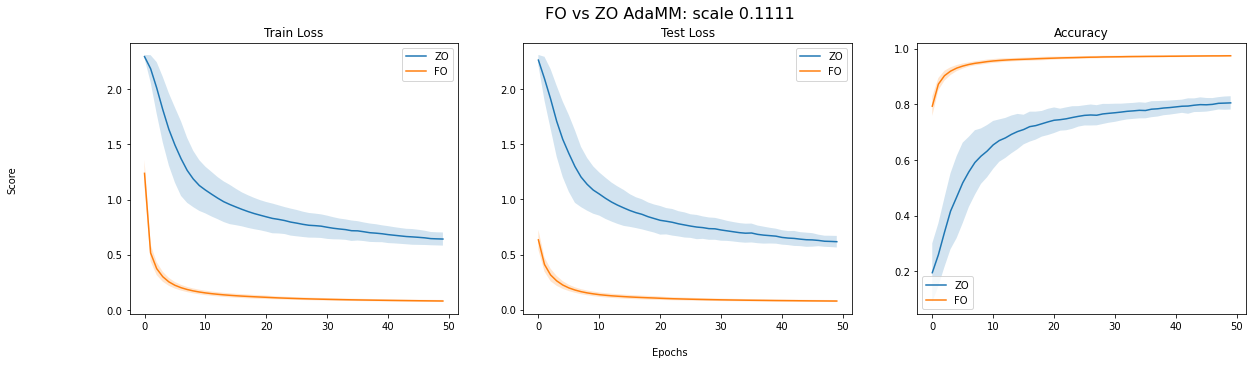

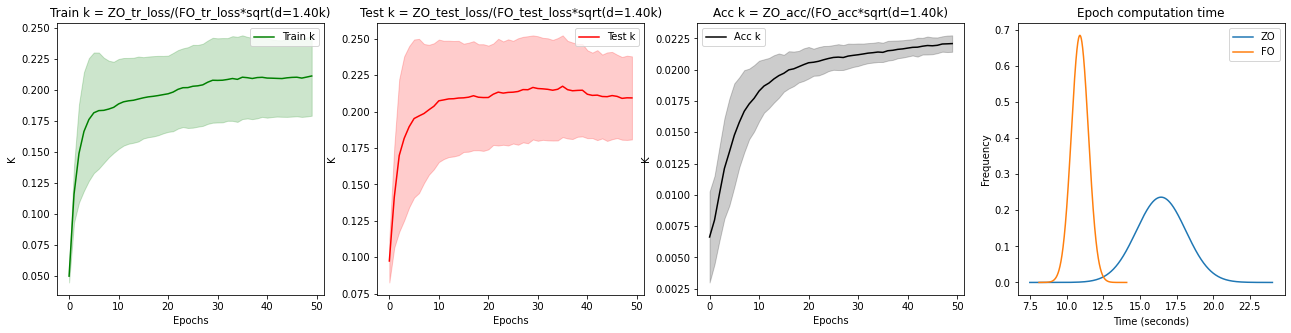

In [9]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_0.111111.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_0.111111.json'))

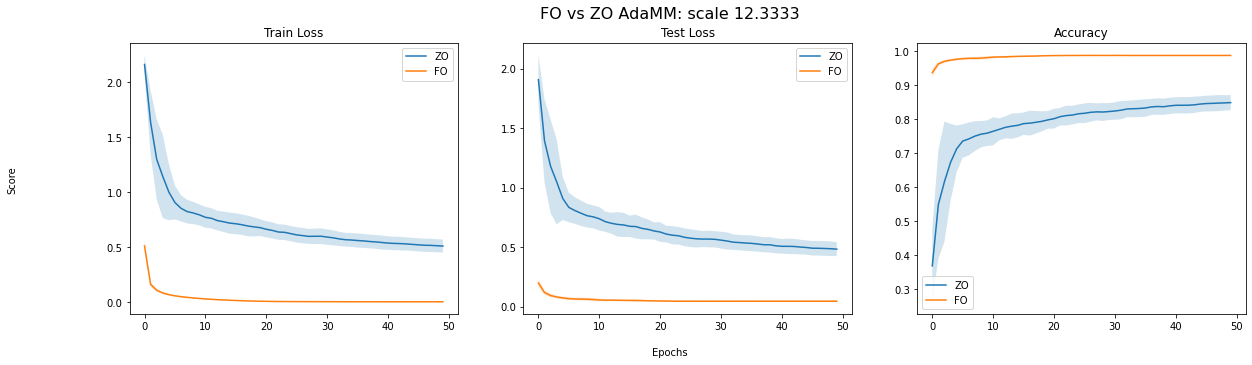

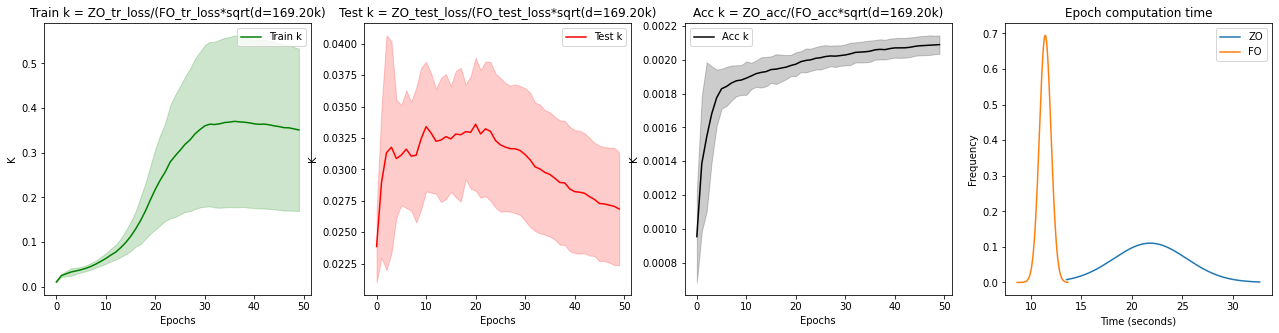

In [10]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_12.333333.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_12.330000.json'))

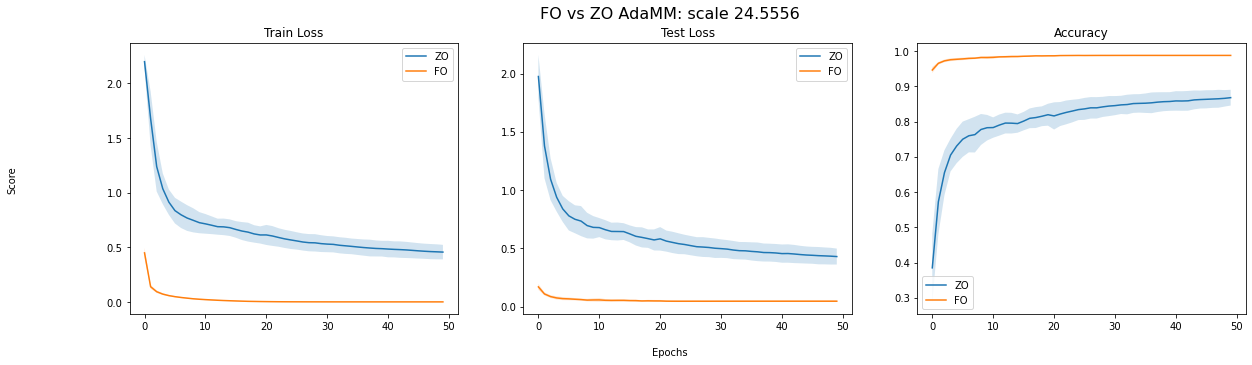

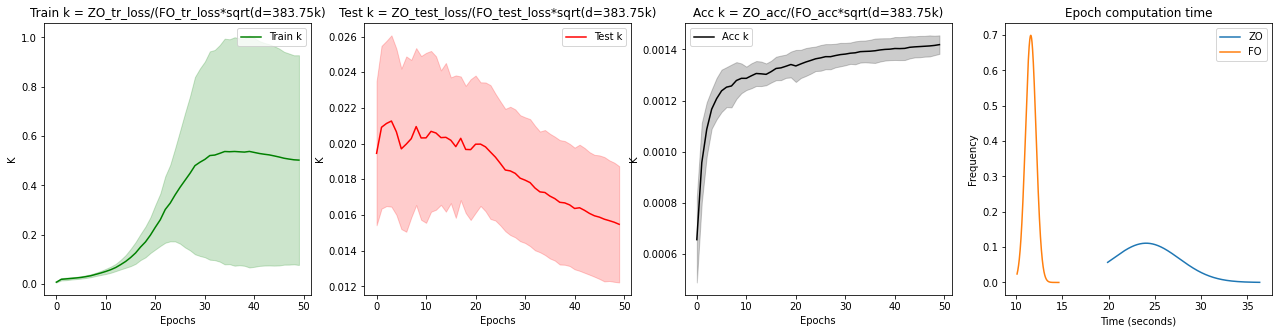

In [11]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_24.555555.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_24.549999.json'))

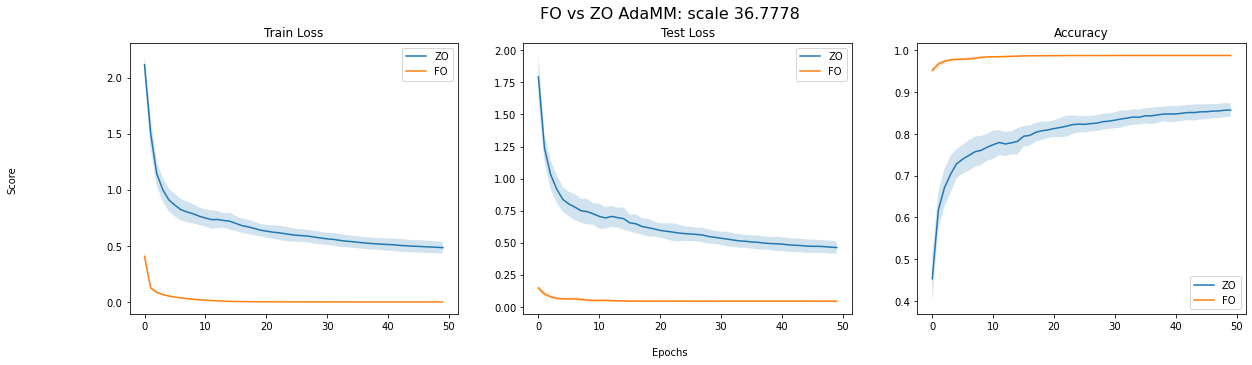

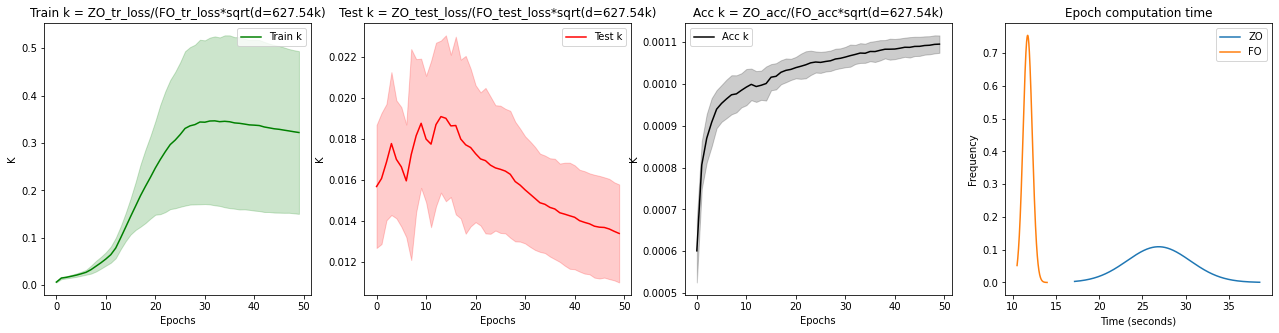

In [12]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_36.777779.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_36.770000.json'))

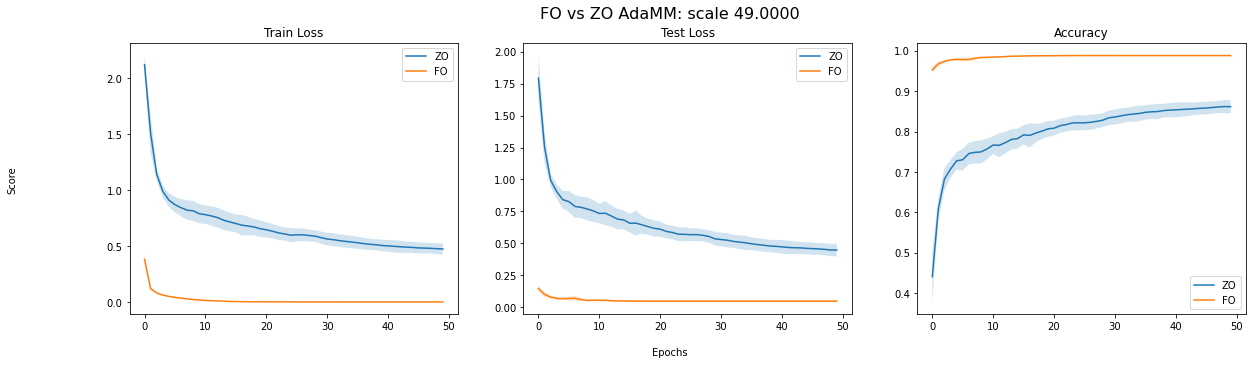

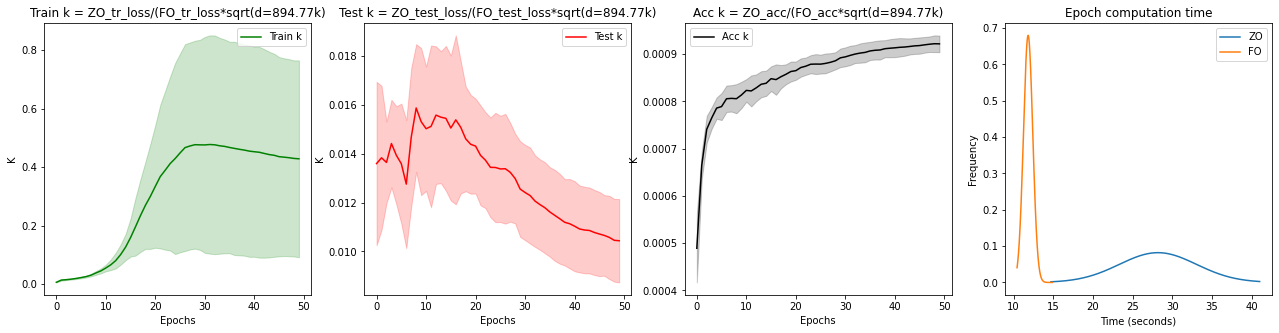

In [13]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_49.000000.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_49.000000.json'))

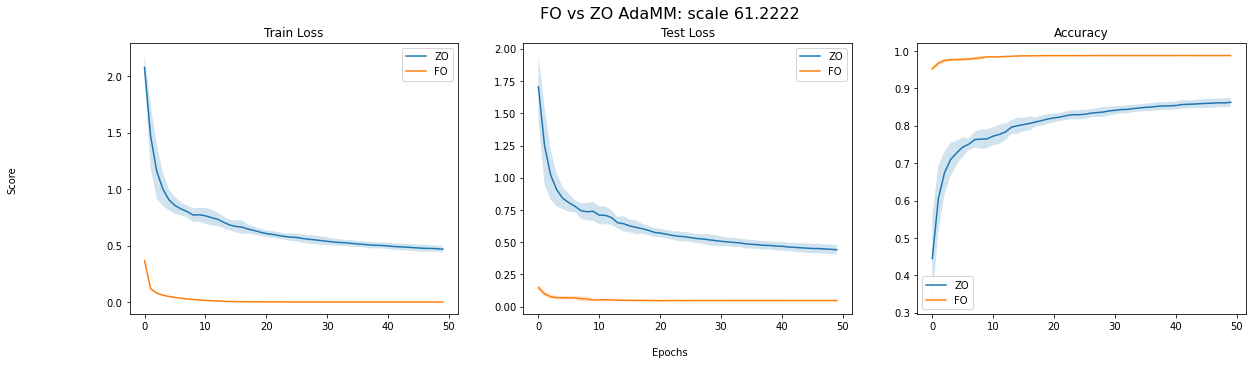

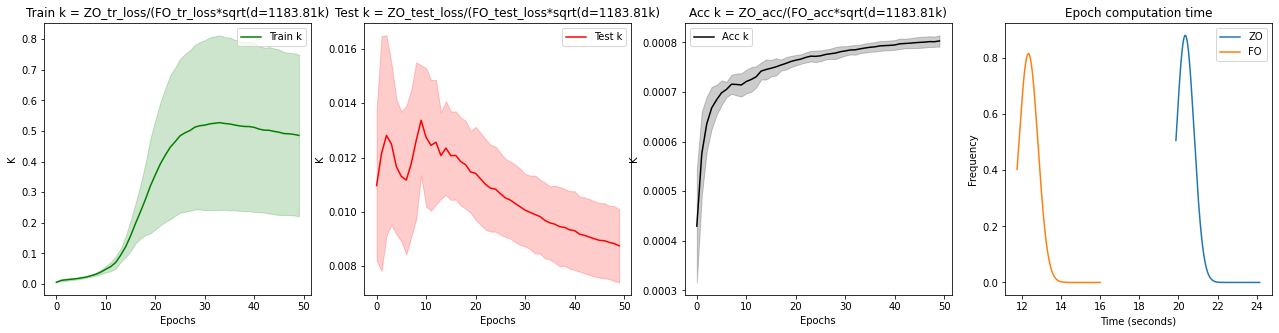

In [14]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_61.222221.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_61.222221.json'))

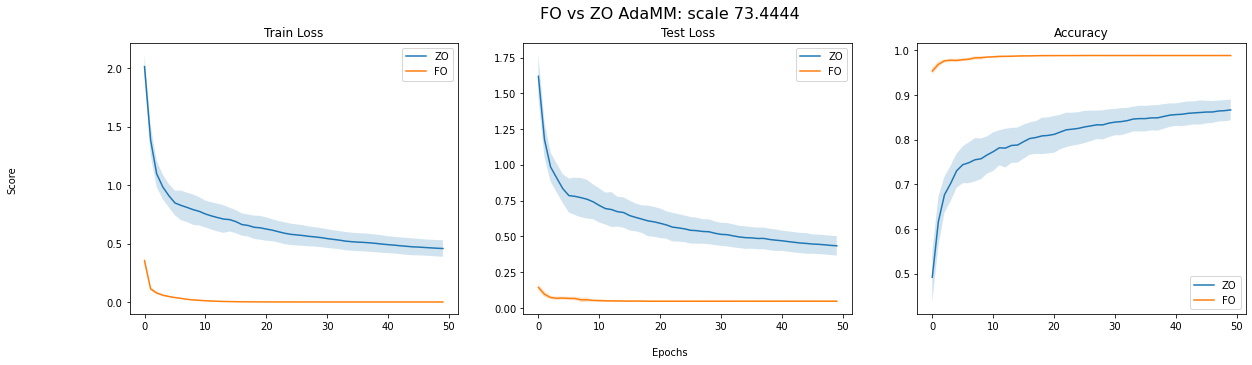

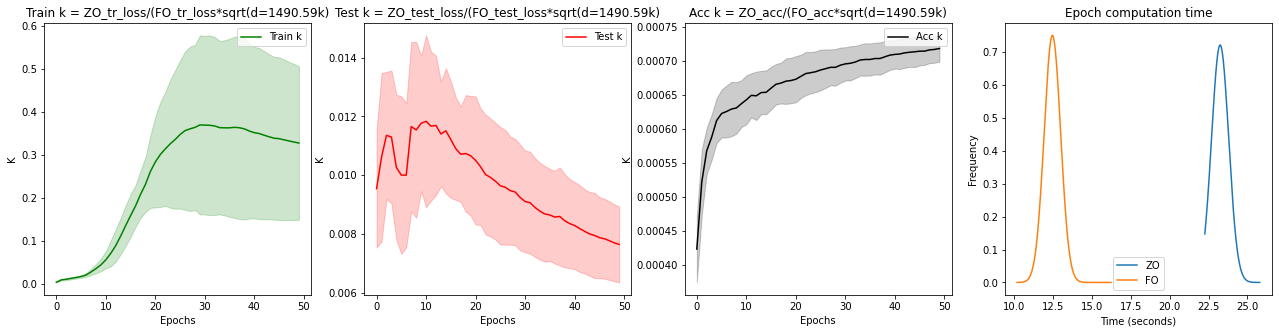

In [15]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_73.444443.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_73.444443.json'))

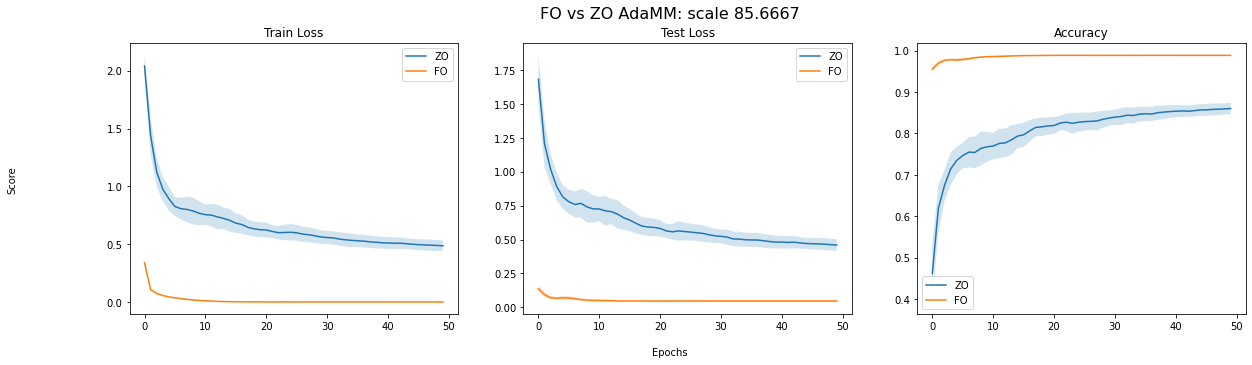

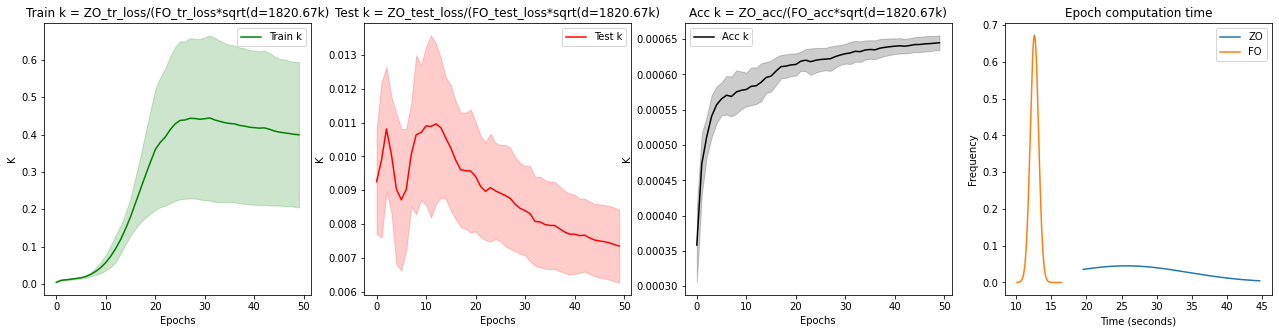

In [16]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_85.666664.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_85.666664.json'))

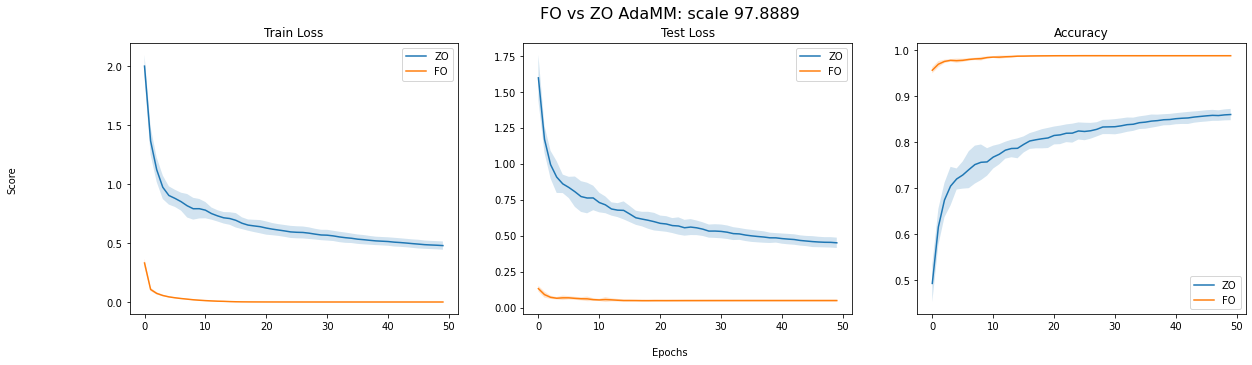

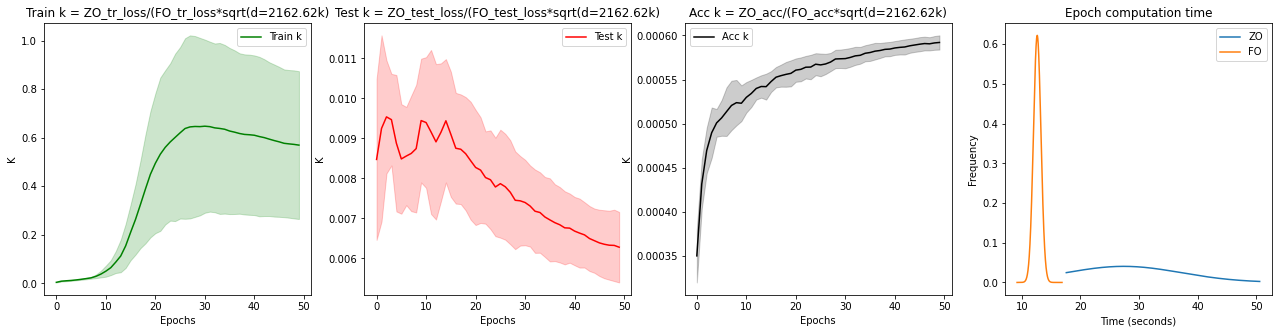

In [17]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_97.888885.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_97.888885.json'))

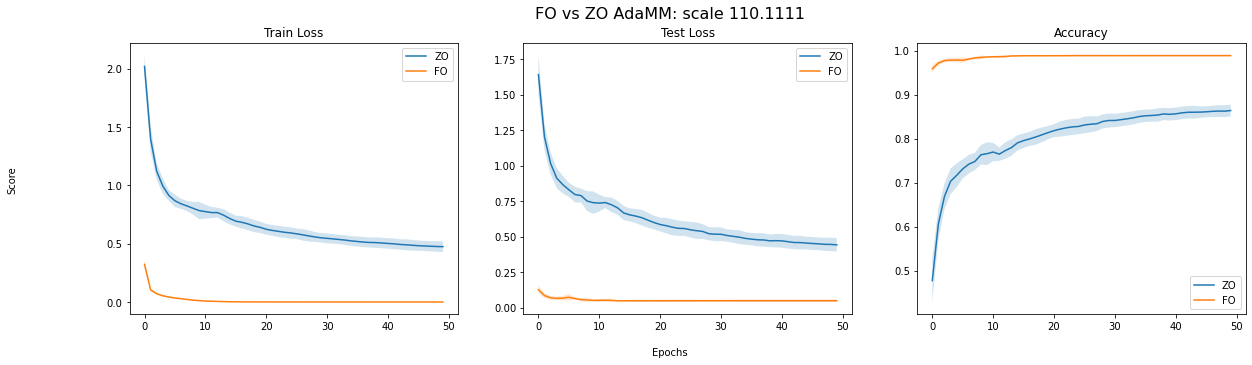

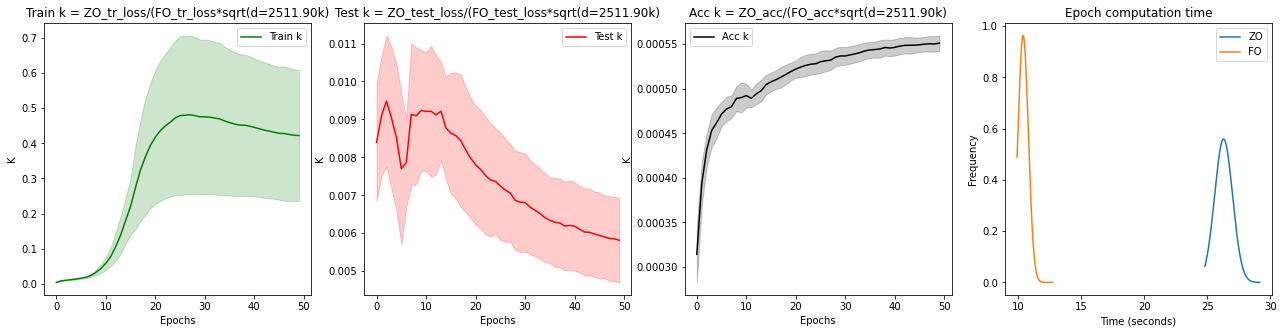

In [18]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_110.111107.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_110.111107.json'))

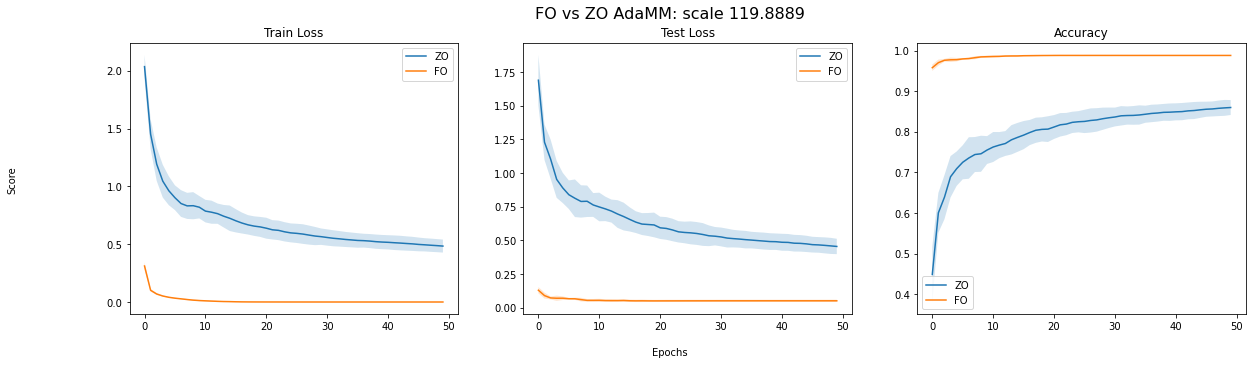

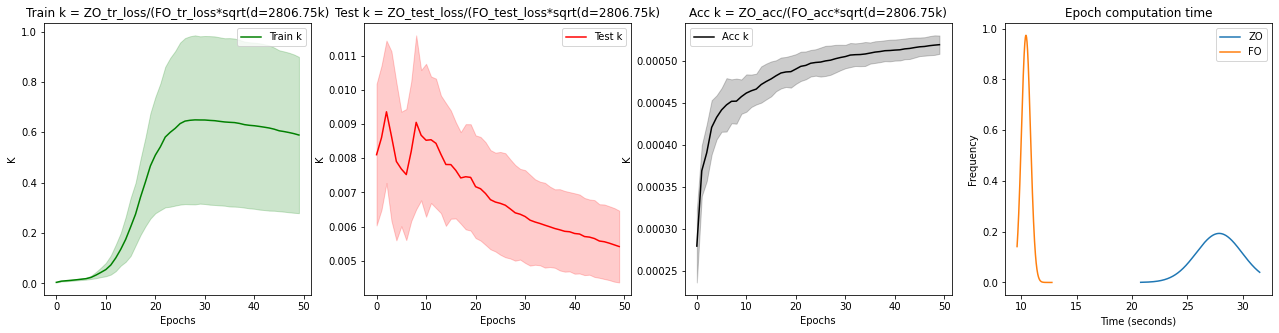

In [19]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_119.888885.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_119.888885.json'))

# Summary for K values

TODO